# Solar-Storage-Microgrid-Sim

## Project Overview

This project, **Solar-Storage-Microgrid-Sim**, aims to create a simple yet comprehensive simulation environment for a photovoltaic (PV) panel, battery, and inverter system integrated with the electrical grid. The simulation also interfaces with real-time energy pricing from the Electric Reliability Council of Texas (ERCOT) to enable dynamic economic decision-making based on current market conditions. (Note I was going to use the gridstatus ERCOT API but instead I may loop through existing days data to simulate real time data to make it easier for anyone to use without an API key.)

## Key Components

1. **PV Panel Simulation**: Models the behavior of solar panels over time, accounting for variables such as sunlight intensity and angle to predict energy production throughout the day.
2. **Battery Storage Model**: Simulates a battery system with realistic charge and discharge cycles, including efficiency losses and capacity limits that change as the battery charges or discharges.
3. **Inverter System**: Converts the DC output from the solar panels and battery storage into AC, mimicking the function of a real-world inverter with sinusoidal output waveform generation.
4. **Economic Analysis**: Integrates ERCOT energy pricing to calculate potential revenue from energy fed back into the grid, supporting strategic operational decisions for maximum economic benefit.

## Objective

The primary goal is to provide a tool for analyzing and optimizing the performance and economic returns of solar storage systems. This simulator will help in understanding how various factors, such as energy price fluctuations and storage capacity, impact the overall efficiency and profitability of solar power systems.

## Technology Stack

- **Python**: Utilized for its libraries listed below specific to modeling pv system and batteries, the ease of data integration with pandas for ERCOT data, and acess to visualization libraries and potentially ML libraries down the line.
- **Jupyter Notebook**: Used to allow me to prototype segments of code and comment on the process better
- **Libraries**: Uses `pvlib` for PV system simulation, `PyBaMM` for battery management, and other Python packages for data handling and visualization.


In [ ]:
import pandas as pd
import numpy as np
import pvlib


In [3]:
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


In [ ]:
# Define location (Austin, TX)
location = Location(latitude=30.2672, longitude=-97.7431, tz='America/Chicago')

# Get 1 year of hourly Weather Data for location
tmy_data, months_selected, location_meta, inputs_outputs = pvlib.iotools.get_pvgis_tmy(latitude=location.latitude, longitude=location.longitude)

#fix date time to Central Time
tmy_data.index = pd.to_datetime(tmy_data.index)  # Ensure the index is in datetime format if not already
tmy_data.index = tmy_data.index.tz_convert('America/Chicago')

# Now `tmy_data` is in the Central Time Zone, you can inspect or plot the data
tmy_data

In [47]:
#specify the summer solstice as theoretical max (for fun/limit test) and only go from 8am to 8pm
# june_21_data = tmy_data.loc[tmy_data.index.month == 6]
# june_21_data = june_21_data.loc[june_21_data.index.day == 21]

june_21_full_day = tmy_data.loc[(tmy_data.index.month == 6) & (tmy_data.index.day == 21)]
daylight_hours = june_21_full_day.between_time('8:00', '20:00')
daylight_hours

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2015-06-21 08:00:00-05:00,25.09,88.35,125.0,54.18,109.0,425.78,4.29,161.0,99726.0
2015-06-21 09:00:00-05:00,25.85,88.92,129.0,0.00,129.0,427.65,5.16,163.0,99746.0
2015-06-21 10:00:00-05:00,26.03,88.70,126.0,0.00,126.0,427.82,5.00,164.0,99752.0
2015-06-21 11:00:00-05:00,26.20,88.49,446.0,78.90,381.0,427.98,4.84,166.0,99759.0
2015-06-21 12:00:00-05:00,26.38,88.27,293.0,15.07,279.0,428.15,4.68,167.0,99765.0
2015-06-21 13:00:00-05:00,26.44,82.87,289.0,15.23,274.0,429.92,4.86,167.0,99716.0
2015-06-21 14:00:00-05:00,26.50,77.47,310.0,16.21,294.0,431.68,5.05,166.0,99667.0
2015-06-21 15:00:00-05:00,26.56,72.07,398.0,29.92,370.0,433.45,5.24,166.0,99618.0
2015-06-21 16:00:00-05:00,26.76,71.44,606.0,248.07,399.0,434.23,4.59,163.0,99599.0


/var/folders/7g/mzy0m5_s7g57zhqxggd9lgz80000gn/T/ipykernel_49386/3423327254.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(june_21_full_day.index, june_21_full_day['ghi'], 'b-o', linestyle='--', label='GHI')  # Blue dotted line with circle markers


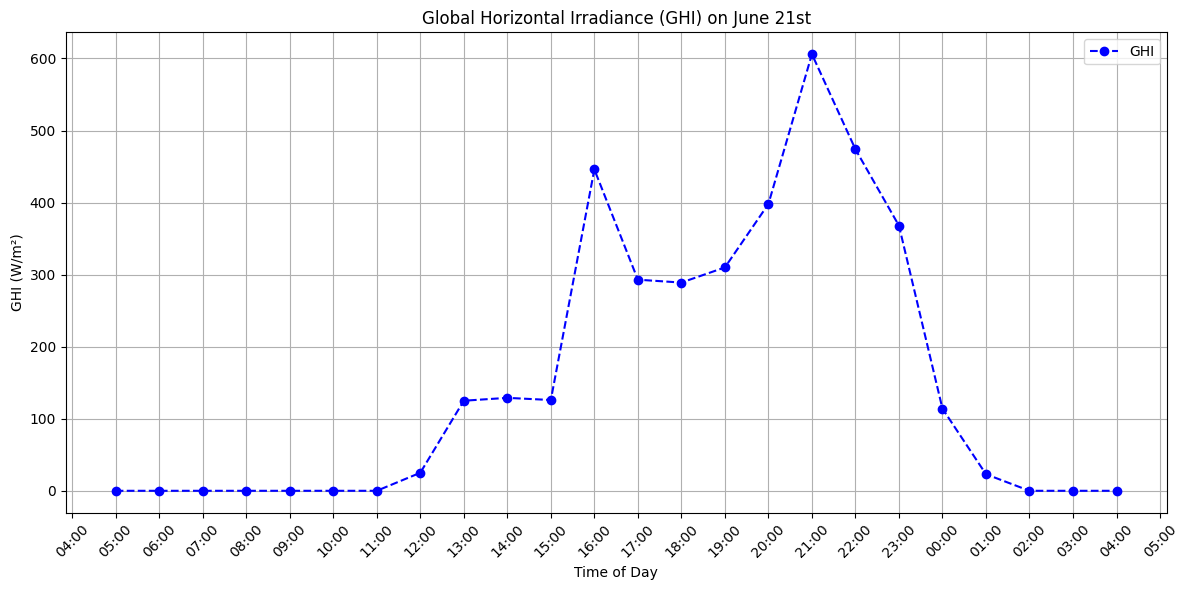

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Check if 'ghi' column exists in the data
if 'ghi' in june_21_full_day.columns:
    plt.figure(figsize=(12, 6))  # Set the figure size for better readability
    plt.plot(june_21_full_day.index, june_21_full_day['ghi'], 'b-o', linestyle='--', label='GHI')  # Blue dotted line with circle markers

    # Format the x-axis to show only the time
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Only show the hour and minute
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set major ticks to be every hour
    
    plt.title('Global Horizontal Irradiance (GHI) on June 21st')
    plt.xlabel('Time of Day')
    plt.ylabel('GHI (W/m²)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)  # Enable grid for easier visualization
    plt.legend()
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
    plt.show()
else:
    print("GHI data not available in the dataset.")


In [ ]:
# Save the weather DataFrame to a CSV file
tmy_data.to_csv('tmy_data.csv', index=True)

In [ ]:
# Load the CSV file back into a DataFrame
tmy_data_loaded = pd.read_csv('tmy_data.csv', index_col=0, parse_dates=True)

# Display the first few rows to confirm it loaded correctly
print(tmy_data_loaded.head())

In [49]:

# Instantiate the ModelChain
#specify calculate dc output with sapm model and ensure no ac since going right to battery want to avoid conversion
mc = ModelChain(system, location, dc_model='sapm')

# Run model with specified hours
mc.run_model(daylight_hours)

# Get DC output
dc_output = mc.results.dc['p_mp']  # DC power output in watts
print(dc_output)



time(UTC)
2015-06-21 08:00:00-05:00     21.664111
2015-06-21 09:00:00-05:00     24.320714
2015-06-21 10:00:00-05:00     23.297100
2015-06-21 11:00:00-05:00     86.358393
2015-06-21 12:00:00-05:00     56.247784
2015-06-21 13:00:00-05:00     55.327970
2015-06-21 14:00:00-05:00     59.480572
2015-06-21 15:00:00-05:00     76.905835
2015-06-21 16:00:00-05:00    115.583169
2015-06-21 17:00:00-05:00     89.392910
2015-06-21 18:00:00-05:00     63.932679
2015-06-21 19:00:00-05:00     20.889558
2015-06-21 20:00:00-05:00      3.359015
Name: p_mp, dtype: float64


# Battery Analysis Section

## Introduction
This section focuses on the simulation and analysis of battery storage systems integrated with solar power data. We'll use the processed TMY data to simulate how a battery would perform with simulated solar dc output (interpolated from hourly data)


## Objectives
- **Simulation of Battery Charging and Discharging Cycles**: Utilize the daylight solar power data to charge the battery and simulate its discharging during non-daylight hours or low irradiance periods.
- **Analysis of Battery Efficiency**: Evaluate the efficiency of the battery system under various load conditions.
- **State of Charge Management**: Explore different algorithms and strategies for maintaining optimal SoC levels to extend battery life and avoid deep discharge cycles.

## Methodology
1. **Data Preparation**: Load and preprocess solar power data (GHI) to represent realistic charging conditions.
2. **Battery Model Setup**: Configure the battery model parameters in PyBaMM or similar simulation tools.
3. **Simulation Execution**: Run the simulations for defined scenarios — e.g., continuous charging and peak shaving.
4. **Result Analysis**: Analyze the output from the simulations to evaluate performance metrics such as cycle life, efficiency, and SoC behavior.

## Simulation Setup
Describe how you set up your simulation environment, including any specific configurations related to the battery model.

In [ ]:
import pybamm

# Set up the battery model
model = pybamm.lithium_ion.SPMe()  # Using Single Particle Model with Electrolyte

# Create a PyBaMM simulation
sim = pybamm.Simulation(model)

# Generate a time variable consistent with your simulation time step
time = np.linspace(0, len(dc_power) * 3600, len(dc_power))  # time in seconds

# Define an interpolant for the DC power as a function of time
power_interpolant = pybamm.Interpolant(time, dc_power.values.flatten(), name="Power input")

# Update the model to use the power interpolant as the input current
def current_function(t):
    return power_interpolant(t) / model.default_parameter_values['Nominal cell voltage']

model.variables["Current [A]"] = current_function

# Solve the model
solver = pybamm.CasadiSolver(mode='fast')
t_eval = np.linspace(0, time[-1], 100)  # Evaluate over the simulation period
solution = solver.solve(model, t_eval)

# Plot the results
pybamm.dynamic_plot(solution)


In [52]:
import numpy as np
import pybamm

# Set up the battery model
model = pybamm.lithium_ion.SPMe()  # Using Single Particle Model with Electrolyte
solver = pybamm.CasadiSolver(mode='fast')

# Prepare to collect results
hourly_results = []

# Loop through each hour of daylight_hours
for hour in range(len(dc_output)):
    # Assume dc_output is indexed by hour and has length equal to the number of hours in daylight_hours
    power_input = dc_output[hour]  # Power input from the PV system for this hour

    # Define the simulation time for one hour
    simulation_time = np.linspace(0, 3600, 100)  # Simulate from 0 to 3600 seconds (1 hour)

    # Define the input current based on the power input
    current_input = power_input / model.default_parameter_values['Nominal cell voltage']

    # Create an experiment to run the model for one hour with a constant current input
    experiment = pybamm.Experiment(
        operating_conditions=[f"Run at {current_input} A for 1 hour"],
        period="1 minute"  # Control the simulation resolution
    )

    # Set up the simulation with the defined experiment
    sim = pybamm.Simulation(model, experiment=experiment, solver=solver)

    # Run the simulation
    sim.solve(simulation_time)

    # Collect the result for this hour
    hourly_results.append(sim)

# After the loop, you can analyze hourly_results which contains the simulation output for each hour


/var/folders/7g/mzy0m5_s7g57zhqxggd9lgz80000gn/T/ipykernel_49386/2679751390.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  power_input = dc_output[hour]  # Power input from the PV system for this hour


KeyError: "'Nominal cell voltage' not found. Best matches are ['Nominal cell capacity [A.h]']"

In [ ]:
import pybamm
from pybamm import ParameterValues

# Load the default parameter set for a lithium iron phosphate battery
params = ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# Update parameters based on SL-1000 specifications
params.update({
    "Nominal cell capacity [A.h]": 1000 / 36.4,  # Total capacity / Nominal voltage to get Amp-hours
    "Nominal cell voltage [V]": 36.4,
    "Maximum continuous charge current [A]": 15,
    "Maximum continuous discharge current [A]": 15,
    "Lower voltage cut-off [V]": 22,
    "Upper voltage cut-off [V]": 45,
    "Ambient temperature [K]": 25 + 273.15,  # Assuming room temperature for baseline
    "Number of cells connected in series": 10,  # Estimated based on nominal voltage, adjust as necessary
    "Number of cells connected in parallel": 3,  # Estimated based on capacity, adjust as necessary
    "Cell cooling surface area [m2]": 0.1,  # Estimated, adjust based on actual measurements
    "Cell thermal conductivity [W.m-1.K-1]": 1,  # Typical for LiFePO4
    "Thermal model": "lumped",
})

# Choose a battery model
model = pybamm.lithium_ion.SPMe()


In [54]:
import pybamm
import numpy as np

# Define parameters based on the provided list
params = {
    "Nominal cell voltage [V]": 36.4,  # Use nominal voltage if provided
    "Nominal cell capacity [A.h]": 1000 / 36.4,  # Calculate using total Wh and nominal voltage
    "Cell cooling surface area [m2]": 0.00531,
    "Cell volume [m3]": 2.42e-05,
    "Electrode height [m]": 0.065,
    "Electrode width [m]": 1.58,
    "Lower voltage cut-off [V]": 2.5,
    "Upper voltage cut-off [V]": 4.2,
    "Maximum continuous charge current [A]": 15,  # Assumed from maximum input current
    "Maximum continuous discharge current [A]": 15,  # Assumed from maximum output current
    "Ambient temperature [K]": 298.15
}

# Define the model and update parameters
model = pybamm.lithium_ion.SPMe()
parameter_values = pybamm.ParameterValues(params, chemistry=pybamm.parameter_sets.Chen2020)
#parameter_values.update(params, check_already_exists=False)

# Create a simulation object
sim = pybamm.Simulation(model, parameter_values=parameter_values)

# Define a simple cycling experiment to reflect typical usage
experiment = pybamm.Experiment(
    [
        "Charge at 15 A until 4.2 V",
        "Rest for 1 hour",
        "Discharge at 15 A until 2.5 V",
        "Rest for 1 hour"
    ],
    period="1 minute"
)

# Run the simulation
solution = sim.solve(experiment=experiment)

# Plot the results
pybamm.dynamic_plot(solution)


/var/folders/7g/mzy0m5_s7g57zhqxggd9lgz80000gn/T/ipykernel_49386/2820584451.py:21: DeprecationWarning: Parameter sets should be called directly by their name (Chen2020), instead of via pybamm.parameter_sets (pybamm.parameter_sets.Chen2020).
  parameter_values = pybamm.ParameterValues(params, chemistry=pybamm.parameter_sets.Chen2020)


ValueError: The 'chemistry' keyword argument has been deprecated. Call `ParameterValues` with a dictionary dictionary of parameter values, or the name of a parameter set (string), as the single argument, e.g. `ParameterValues('Chen2020')`.

In [55]:
import pybamm

# Define your custom parameters
custom_params = {
    "Nominal cell capacity [A.h]": 1000 / 36.4,  # Calculate capacity from Wh and V
    "Cell cooling surface area [m2]": 0.00531,
    "Cell volume [m3]": 2.42e-05,
    "Electrode height [m]": 0.065,
    "Electrode width [m]": 1.58,
    "Lower voltage cut-off [V]": 2.5,
    "Upper voltage cut-off [V]": 4.2,
    "Maximum continuous charge current [A]": 15,
    "Maximum continuous discharge current [A]": 15,
    "Ambient temperature [K]": 298.15,
    "Initial temperature [K]": 298.15  # Example of setting initial conditions if needed
}

# Load a predefined parameter set from PyBaMM
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

# Update the predefined parameters with your custom ones
parameter_values.update(custom_params, check_already_exists=False)

# Define the model
model = pybamm.lithium_ion.SPMe()

# Create a simulation object using the updated parameter values
sim = pybamm.Simulation(model, parameter_values=parameter_values)

# Define a simple cycling experiment to reflect typical usage
experiment = pybamm.Experiment(
    [
        "Charge at 15 A until 4.2 V",
        "Rest for 1 hour",
        "Discharge at 15 A until 2.5 V",
        "Rest for 1 hour"
    ],
    period="1 minute"  # Defines the time step of the simulation
)

# Run the simulation
solution = sim.solve(experiment=experiment)

# Plot the results
pybamm.dynamic_plot(solution)


/var/folders/7g/mzy0m5_s7g57zhqxggd9lgz80000gn/T/ipykernel_49386/1390973698.py:19: DeprecationWarning: Parameter sets should be called directly by their name (Chen2020), instead of via pybamm.parameter_sets (pybamm.parameter_sets.Chen2020).
  parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)


TypeError: ParameterValues.__init__() missing 1 required positional argument: 'values'